# Анализ сетевого трафика методом SVM
Содержание работы:
- исходный набор данных
- импорт библиотек
- предобработка данных
- построение моделей SVM
- обучение моделей SVM
- выбор наилучшего результата
- документация

## Исходный набор данных

Intrusion detection evaluation dataset (CIC-IDS2017) / Набор данных для оценки обнаружения вторжений (CIC-IDS2017) (https://www.unb.ca/cic/datasets/ids-2017.html)

Это набор данных, предназначенный для оценки систем обнаружения вторжений (IDS). Он включает как нормальный, так и вредоносный сетевой трафик.. Данные собирались в течение пяти дней (с 3 по 7 июля 2017 года) и включают различные типы атак, такие как Brute Force FTP, SSH, DoS, Heartbleed, Web Attack, Infiltration, Botnet и DDoS.

Типы атак по дням в датасете:
- Tuesday, July 4, 2017. Brute Force. FTP-Patator (9:20 – 10:20 a.m.)
- Wednesday, July 5, 2017. DoS / DDoS, DoS slowloris (9:47 – 10:10 a.m.), DoS Slowhttptest (10:14 – 10:35 a.m.), DoS Hulk (10:43 – 11 a.m.), DoS GoldenEye (11:10 – 11:23 a.m.)
- Thursday, July 6, 2017. Morning: Web Attack – Brute Force (9:20 – 10 a.m.), Web Attack – XSS (10:15 – 10:35 a.m.), Web Attack – Sql Injection (10:40 – 10:42 a.m.), SSH-Patator (14:00 – 15:00 p.m.). Afternoon: Infiltration – Dropbox download, Meta exploit Win Vista (14:19 and 14:20-14:21 p.m.) and (14:33 -14:35), Infiltration – Cool disk – MAC (14:53 p.m. – 15:00 p.m.), Infiltration – Dropbox download, Win Vista (15:04 – 15:45 p.m.)
- Friday, July 7, 2017. Morning: Botnet ARES (10:02 a.m. – 11:02 a.m.). Port Scan: Firewall Rule on (13:55 – 13:57, 13:58 – 14:00, 14:01 – 14:04, 14:05 – 14:07, 14:08 - 14:10, 14:11 – 14:13, 14:14 – 14:16, 14:17 – 14:19, 14:20 – 14:21, 14:22 – 14:24, 14:33 – 14:33, 14:35 - 14:35), Firewall rules off (sS 14:51-14:53, sT 14:54-14:56, sF 14:57-14:59, sX 15:00-15:02, sN 15:03-15:05, sP 15:06-15:07, sV 15:08-15:10, sU 15:11-15:12, sO 15:13-15:15, sA 15:16-15:18, sW 15:19-15:21, sR 15:22-15:24, sL 15:25-15:25, sI 15:26-15:27, b 15:28-15:29), DDoS LOIT (15:56 – 16:16)

Также содержится нормальный трафик (Понедельник), сгенерированный 25 пользователями с использованием таких протоколов, как HTTP, HTTPS, FTP, SSH и email.

Цельюю анализа является предсказание: является ли наблюдаемый сетевой трафик нормальным или вредоносным. Модель будет классифицировать поток данных как "нормальный" или "вредоносный" трафик на основе признаков, которые использовались для обучения модели.

На странице представлены две директории: "CSVs/" и "PCAPs/"
- PCAPs/: содержит данные в формате PCAP (Packet Capture). PCAP-файлы содержат сырые сетевые пакеты, которые захвачены непосредственно с сетевого интерфейса.
- CSVs/: содержит данные в формате CSV. CSV-файлы уже содержат извлеченные и обработанные признаки сетевого трафика, такие как количество пакетов, байтов, длительность сессии и т.д.

В работе были использованы следующие архивы:
- 	GeneratedLabelledFlows.zip
- 	MachineLearningCSV.zip
Архивы были предварительно распакованы и помещены в рабочее пространства Google Colab.

## Импорт используемых библиотек

In [ ]:
# Импорт библиотеки для работы с операционной системой и файловой системой
import os
# Импорт библиотеки для управления сборщиком мусора (garbage collector) в Python
import gc

# Импорт библиотеки для работы с данными и анализа данных в табличной форме
import pandas as pd
# библиотека для работы с многомерными массивами и матрицами, а также для выполнения математических и логических операций
import numpy as np
# библиотека для создания различных видов графиков и диаграмм
import matplotlib.pyplot as plt

# Импорт библиотеки для разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
# Импорт библиотеки для нормализации данных, приводя их значения к диапазону от 0 до 1
from sklearn.preprocessing import MinMaxScaler


# Функция variance_inflation_factor используется для вычисления коэффициента инфляции дисперсии (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Импорт библиотеки для метода опорных векторов (SVM) из sklearn
from sklearn.svm import SVC

# Импорт GridSearchCV для решетчатого поиска и ParameterGrid для генерации комбинаций параметров
from sklearn.model_selection import GridSearchCV, ParameterGrid
# Импорт make_scorer для создания пользовательской функции оценки
from sklearn.metrics import  make_scorer
# Импорт функции clone для создания копий модели
from sklearn.base import clone

# Импорт библиотеки для выполнения решетчатого поиска (Grid Search) для настройки гиперпараметров модели
from sklearn.model_selection import GridSearchCV

# Импорт библиотек для оценки модели с использованием различных метрик
from sklearn.metrics import classification_report  # Отчет по классификации, включающий основные метрики
from sklearn.metrics import accuracy_score  # Точность модели
from sklearn.metrics import precision_score  # Прецизионность модели
from sklearn.metrics import recall_score  # Полнота модели
from sklearn.metrics import f1_score  # F1-мера
from sklearn.metrics import roc_auc_score  # Площадь под ROC кривой (AUC)

### Подключение к гугл-диску

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# путь к рабочей директории на Google Диске
working_directory = '/content/drive/My Drive/Colab Notebooks/Dataset/CICAndAdGMal2017'
os.chdir(working_directory)

## Предварительная обработка данных
- загрузка данных (сбор рабочего датафрейма из исходного датасета - создание одного файла из нескольких)
- корреляция, мультиколлениарность, выбор признаков модели
- нормализация (при необходимости)
- разделение данных на тренировочный, тестовый, валидационный наборы

### Загрука данных

In [ ]:
# Вывод содержимого папки с метками
labels_directory = os.path.join(working_directory, "TrafficLabelling_")
labels_content = os.listdir(labels_directory)
print('Содержимое папки "TrafficLabelling_":')
labels_content

Содержимое папки "TrafficLabelling_":


['Monday-WorkingHours.pcap_ISCX.csv',
 'Wednesday-workingHours.pcap_ISCX.csv',
 'Tuesday-WorkingHours.pcap_ISCX.csv',
 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
 'Friday-WorkingHours-Morning.pcap_ISCX.csv',
 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv']

In [ ]:
# Вывод содержимого папки с набором данных
data_directory = os.path.join(working_directory, "MachineLearningCVE")
data_content = os.listdir(data_directory)
print('\nСодержимое папки "MachineLearningCVE":')
data_content


Содержимое папки "MachineLearningCVE":


['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
 'Friday-WorkingHours-Morning.pcap_ISCX.csv',
 'Monday-WorkingHours.pcap_ISCX.csv',
 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
 'Tuesday-WorkingHours.pcap_ISCX.csv',
 'Wednesday-workingHours.pcap_ISCX.csv']

In [ ]:
# Функция для преобразования .csv файлов в директории в датафреймы с учетом возможных кодировок
def create_dataframes(directory):
    # Получаем список всех файлов в директории
    files = os.listdir(directory)
    # Создаем пустой словарь для хранения датафреймов
    dataframes = {}
    # Проходим по каждому файлу в директории
    for file in files:
        # Проверяем, что файл имеет расширение .csv
        if file.endswith('.csv'):
            # Создаем полный путь к файлу
            file_path = os.path.join(directory, file)
            try:
                # Попробуем сначала использовать кодировку utf-8
                df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)
            except UnicodeDecodeError:
                print(f'Ошибка декодирования файла {file} с использованием кодировки utf-8. Пробую использовать кодировку ISO-8859-1.')
                try:
                    # Если utf-8 не сработает, попробуем ISO-8859-1
                    df = pd.read_csv(file_path, encoding='ISO-8859-1', low_memory=False)
                except UnicodeDecodeError:
                    # Если обе кодировки не сработают, пропускаем файл
                    print(f'Ошибка декодирования файла {file} с использованием кодировки ISO-8859-1.')
                    continue
            # Сохраняем датафрейм в словарь с именем файла в качестве ключа
            dataframes[file] = df
    # Возвращаем словарь датафреймов
    return dataframes

In [ ]:
# Вызрв функции create_dataframes для обоих датасетов
traffic_labelling_dataframes = create_dataframes(labels_directory)
machine_learning_cve_dataframes =create_dataframes(data_directory)

Ошибка декодирования файла Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv с использованием кодировки utf-8. Пробую использовать кодировку ISO-8859-1.


In [ ]:
# Вывод списков ключей (названий файлов) из словарей dataframes для проверки загруженных .csv файлов
print(list(traffic_labelling_dataframes.keys()))
print(list(machine_learning_cve_dataframes.keys()))

['Monday-WorkingHours.pcap_ISCX.csv', 'Wednesday-workingHours.pcap_ISCX.csv', 'Tuesday-WorkingHours.pcap_ISCX.csv', 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv']
['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv', 'Monday-WorkingHours.pcap_ISCX.csv', 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 'Tuesday-WorkingHours.pcap_ISCX.csv', 'Wednesday-workingHours.pcap_ISCX.csv']


In [ ]:
# вывод первых строк набора
traffic_labelling_dataframes['Monday-WorkingHours.pcap_ISCX.csv'].head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80,192.168.10.5,49188,6,03/07/2017 08:55:58,4,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80,192.168.10.5,49188,6,03/07/2017 08:55:58,1,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80,192.168.10.5,49188,6,03/07/2017 08:55:58,1,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80,192.168.10.5,49188,6,03/07/2017 08:55:58,1,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.14-8.253.185.121-49486-80-6,8.253.185.121,80,192.168.10.14,49486,6,03/07/2017 08:56:22,3,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [ ]:
machine_learning_cve_dataframes['Monday-WorkingHours.pcap_ISCX.csv'].head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
# Получение списка столбцов из датафреймов
traffic_labelling_columns = traffic_labelling_dataframes['Monday-WorkingHours.pcap_ISCX.csv'].columns
machine_learning_cve_columns = machine_learning_cve_dataframes['Monday-WorkingHours.pcap_ISCX.csv'].columns

# Нахождение совпадающих столбцов между двумя наборами данных
common_columns = set(traffic_labelling_columns) & set(machine_learning_cve_columns)

# Нахождение различающихся столбцов между двумя наборами данных
difference_columns = set(traffic_labelling_columns) ^ set(machine_learning_cve_columns)

print(f'Совпадающие столбцы:\n{common_columns}\n')
print(f'Различающиеся столбцы:\n{difference_columns}\n')

Совпадающие столбцы:
{' Label', ' URG Flag Count', 'Fwd Avg Bytes/Bulk', ' Fwd IAT Max', 'Fwd IAT Total', ' Subflow Bwd Bytes', ' Bwd IAT Min', ' Total Length of Bwd Packets', ' Flow Packets/s', ' Fwd IAT Mean', ' Total Fwd Packets', ' ACK Flag Count', ' Active Max', ' Bwd Packet Length Min', 'Bwd Packet Length Max', ' Active Min', ' Average Packet Size', ' PSH Flag Count', ' Active Std', ' Fwd Packet Length Min', 'Fwd PSH Flags', ' SYN Flag Count', ' Bwd Packet Length Std', 'FIN Flag Count', ' Bwd Packets/s', 'Init_Win_bytes_forward', ' Total Backward Packets', ' Fwd Packet Length Mean', ' Fwd IAT Std', ' Bwd IAT Std', 'Subflow Fwd Packets', ' Bwd Header Length', ' ECE Flag Count', ' act_data_pkt_fwd', ' Flow IAT Std', ' Fwd Avg Packets/Bulk', ' Idle Max', ' Flow Duration', ' min_seg_size_forward', ' RST Flag Count', ' Avg Fwd Segment Size', ' Bwd URG Flags', ' Flow IAT Min', ' Packet Length Variance', ' Idle Min', ' Subflow Bwd Packets', ' Down/Up Ratio', ' Min Packet Length', ' Fwd 

In [ ]:
def combine_dataframes(df1, df2):
    # Получение названий столбцов для каждого датафрейма
    df1_columns = df1.columns
    df2_columns = df2.columns

    # Нахождение совпадающих и различающихся столбцов
    common_columns = set(df1_columns) & set(df2_columns)
    difference_columns = set(df1_columns) ^ set(df2_columns)

     #print(f'Совпадающие столбцы:\n{common_columns}\n')
     #print(f'Различающиеся столбцы:\n{difference_columns}\n')

    # Объединение датафреймов по общим столбцам и добавление уникальных столбцов
    combined_df = pd.concat([df1, df2], axis=1)

    # Удаление дубликатов столбцов
    combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]

    return combined_df

In [ ]:
# Функция для объединения всех датафреймов из двух коллекций
def combine_all_dataframes(traffic_labelling_dataframes, machine_learning_cve_dataframes):
    # Создаем пустой словарь для хранения объединенных датафреймов
    combined_dataframes = {}

    # Проходим по всем ключам (именам файлов) из коллекции traffic_labelling_dataframes
    for file_name in traffic_labelling_dataframes.keys():
        # Проверяем, существует ли файл в обеих коллекциях датафреймов
        if file_name in machine_learning_cve_dataframes:
            # Получаем датафреймы из обеих коллекций
            df1 = traffic_labelling_dataframes[file_name]
            df2 = machine_learning_cve_dataframes[file_name]
            # Объединяем датафреймы с использованием функции combine_dataframes
            combined_df = combine_dataframes(df1, df2)
            # Сохраняем объединенный датафрейм в словарь с именем файла в качестве ключа
            combined_dataframes[file_name] = combined_df
        else:
            # Если файл отсутствует в одной из коллекций, выводим сообщение
            print(f'Файл {file_name} отсутствует в обеих коллекциях датафреймов.')

    # Возвращаем словарь объединенных датафреймов
    return combined_dataframes

In [ ]:
# объединение всех наборов в результирующий датафрейм для дальнейшей работы
combined_dataframes = combine_all_dataframes(traffic_labelling_dataframes, machine_learning_cve_dataframes)

In [ ]:
# Функция для проверки согласованности столбцов в объединенных датафреймах
def check_columns_consistency(combined_dataframes):
    # Создаем список всех столбцов из датафреймов в словаре
    columns_list = [df.columns for df in combined_dataframes.values()]
    # Получаем столбцы первого датафрейма в списке
    first_columns = columns_list[0]

    # Проходим по столбцам остальных датафреймов
    for i, columns in enumerate(columns_list[1:], start=1):
        # Проверяем, что все столбцы совпадают с первым датафреймом
        if not all(first_columns == columns):
            # Если столбцы не совпадают, выводим сообщение с номером датафрейма и его столбцами
            print(f"Столбцы не совпадают в датафрейме номер {i+1}:")
            print(f"{columns}\n")
            return False

    # Если все столбцы совпадают, выводим сообщение
    print("Все датафреймы имеют одинаковые столбцы.")
    return True

# Пример вызова функции для проверки согласованности столбцов
check_columns_consistency(combined_dataframes)


Все датафреймы имеют одинаковые столбцы.


True

In [ ]:
# Вывод названий столбцов результирующего датафрейма для примера
example_file_name = 'Monday-WorkingHours.pcap_ISCX.csv'
print(f"Названия столбцов результирующего датафрейма для {example_file_name}:")
print(combined_dataframes[example_file_name].columns)

# Вывод первых строк результирующего датафрейма для примера
print(f"Первые строки результирующего датафрейма для {example_file_name}:")
combined_dataframes[example_file_name].head()

Названия столбцов результирующего датафрейма для Monday-WorkingHours.pcap_ISCX.csv:
Index(['Flow ID', ' Source IP', ' Source Port', ' Destination IP',
       ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration',
       ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Head

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80,192.168.10.5,49188,6,03/07/2017 08:55:58,4,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80,192.168.10.5,49188,6,03/07/2017 08:55:58,1,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80,192.168.10.5,49188,6,03/07/2017 08:55:58,1,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80,192.168.10.5,49188,6,03/07/2017 08:55:58,1,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.14-8.253.185.121-49486-80-6,8.253.185.121,80,192.168.10.14,49486,6,03/07/2017 08:56:22,3,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [ ]:
# Функция для объединения всех датафреймов и подсчета общего количества строк
def merge_all_dataframes(combined_dataframes):
    # Инициализация счетчика общего количества строк
    total_rows = 0

    # Проходим по всем датафреймам в словаре combined_dataframes
    for file_name, df in combined_dataframes.items():
        # Выводим имя файла и количество строк в текущем датафрейме
        print(f"{file_name} содержит {len(df)} строк.")
        # Добавляем количество строк текущего датафрейма к общему счетчику
        total_rows += len(df)

    # Выводим общую сумму строк всех датафреймов
    print(f"\nОбщая сумма строк всех датафреймов: {total_rows}")

    # Объединение всех датафреймов в один датафрейм
    final_combined_df = pd.concat(combined_dataframes.values(), axis=0)

    # Выводим итоговое количество строк в объединенном датафрейме
    print(f"\nИтоговое количество строк в объединенном датафрейме: {len(final_combined_df)}")

    # Возвращаем объединенный датафрейм
    return final_combined_df

# для объединения всех датафреймов
final_combined_df = merge_all_dataframes(combined_dataframes)

Monday-WorkingHours.pcap_ISCX.csv содержит 529918 строк.
Wednesday-workingHours.pcap_ISCX.csv содержит 692703 строк.
Tuesday-WorkingHours.pcap_ISCX.csv содержит 445909 строк.
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv содержит 458968 строк.
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv содержит 288602 строк.
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv содержит 286467 строк.
Friday-WorkingHours-Morning.pcap_ISCX.csv содержит 191033 строк.
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv содержит 225745 строк.

Общая сумма строк всех датафреймов: 3119345

Итоговое количество строк в объединенном датафрейме: 3119345


In [ ]:
# Вывод первых строк объединенного датафрейма
final_combined_df.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,4.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,1.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,1.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,1.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.14-8.253.185.121-49486-80-6,8.253.185.121,80.0,192.168.10.14,49486.0,6.0,03/07/2017 08:56:22,3.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [ ]:
# Удаляем все ненужные объекты
del traffic_labelling_dataframes
del machine_learning_cve_dataframes
del combined_dataframes

# Принудительно вызываем сборщик мусора
gc.collect()

0

In [ ]:
# Сохранение итогового датафрейма на диск
final_combined_df.to_csv('/content/drive/My Drive/Colab Notebooks/Dataset/CICAndAdGMal2017/final_combined_df.csv', index=False)

In [ ]:
#del final_combined_df

# Принудительно вызываем сборщик мусора
#gc.collect()

In [ ]:
# Загрузка итогового датафрейма обратно в память
final_combined_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/CICAndAdGMal2017/final_combined_df.csv')

# Вывод первых строк объединенного датафрейма для проверки
final_combined_df.head()

<ipython-input-27-3236a933da70>:2: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  final_combined_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/CICAndAdGMal2017/final_combined_df.csv')


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,4.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,1.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,1.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,1.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.14-8.253.185.121-49486-80-6,8.253.185.121,80.0,192.168.10.14,49486.0,6.0,03/07/2017 08:56:22,3.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [ ]:
final_combined_df.columns

Index(['Flow ID', ' Source IP', ' Source Port', ' Destination IP',
       ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration',
       ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Pa

In [ ]:
final_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3119345 entries, 0 to 3119344
Data columns (total 85 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Flow ID                       object 
 1    Source IP                    object 
 2    Source Port                  float64
 3    Destination IP               object 
 4    Destination Port             float64
 5    Protocol                     float64
 6    Timestamp                    object 
 7    Flow Duration                float64
 8    Total Fwd Packets            float64
 9    Total Backward Packets       float64
 10  Total Length of Fwd Packets   float64
 11   Total Length of Bwd Packets  float64
 12   Fwd Packet Length Max        float64
 13   Fwd Packet Length Min        float64
 14   Fwd Packet Length Mean       float64
 15   Fwd Packet Length Std        float64
 16  Bwd Packet Length Max         float64
 17   Bwd Packet Length Min        float64
 18   Bwd Packet Length Mea

In [ ]:
# Проверка дубликатов строк
duplicates = final_combined_df.duplicated()

# Вывод количества дубликатов
num_duplicates = duplicates.sum()
print(f"Количество дубликатов: {num_duplicates}")

# Удаление дубликатов с использованием параметра inplace=True
if num_duplicates > 0:
    final_combined_df.drop_duplicates(inplace=True)

# Сброс индекса после удаления дубликатов
final_combined_df.reset_index(drop=True, inplace=True)

# Принудительный вызов сборщика мусора для освобождения памяти
del duplicates
gc.collect()

# Повторный вывод информации о датафрейме после удаления дубликатов
final_combined_df.info()

Количество дубликатов: 288804
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830541 entries, 0 to 2830540
Data columns (total 85 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Flow ID                       object 
 1    Source IP                    object 
 2    Source Port                  float64
 3    Destination IP               object 
 4    Destination Port             float64
 5    Protocol                     float64
 6    Timestamp                    object 
 7    Flow Duration                float64
 8    Total Fwd Packets            float64
 9    Total Backward Packets       float64
 10  Total Length of Fwd Packets   float64
 11   Total Length of Bwd Packets  float64
 12   Fwd Packet Length Max        float64
 13   Fwd Packet Length Min        float64
 14   Fwd Packet Length Mean       float64
 15   Fwd Packet Length Std        float64
 16  Bwd Packet Length Max         float64
 17   Bwd Packet Length Min        float

In [ ]:
# Проверка наличия пропущенных значений
null_counts = final_combined_df.isnull().sum()

# Вывод столбцов с пропущенными значениями
print("Количество пропущенных значений в каждом столбце:")
print(null_counts[null_counts > 0])

# Удаление строк с пропущенными значениями
final_combined_df.dropna(inplace=True)

# Повторный вывод информации о датафрейме после удаления строк с пропущенными значениями
null_counts = final_combined_df.isnull().sum()

# Принудительный вызов сборщика мусора для освобождения памяти
import gc
gc.collect()
null_counts

Количество пропущенных значений в каждом столбце:
Flow ID              1
 Source IP           1
 Source Port         1
 Destination IP      1
 Destination Port    1
                    ..
Idle Mean            1
 Idle Std            1
 Idle Max            1
 Idle Min            1
 Label               1
Length: 85, dtype: int64


,0
Flow ID,0
Source IP,0
Source Port,0
Destination IP,0
Destination Port,0
...,...
Idle Mean,0
Idle Std,0
Idle Max,0
Idle Min,0


### Вывод основных статистических характеристик числовых данных

In [ ]:
final_combined_df.describe()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.829183e+06,2.829183e+06,2.829183e+06,2.829183e+06,2.829183e+06,2.829183e+06,2.829183e+06,2.829183e+06,2.829183e+06,2.829183e+06,...,2.829183e+06,2.829183e+06,2.829183e+06,2.829183e+06,2.829183e+06,2.829183e+06,2.829183e+06,2.829183e+06,2.829183e+06,2.829183e+06
mean,4.112948e+04,8.070288e+03,9.882480e+00,1.479382e+07,9.365289e+00,1.039943e+01,5.496051e+02,1.617155e+04,2.077143e+02,1.872388e+01,...,5.421190e+00,-2.743217e+03,8.159629e+04,4.115680e+04,1.532670e+05,5.832796e+04,8.320622e+06,5.041218e+05,8.700547e+06,7.924398e+06
std,2.229666e+04,1.828272e+04,5.262583e+00,3.366123e+07,7.498794e+02,9.976632e+02,9.996336e+03,2.263712e+06,7.173660e+02,6.035440e+01,...,6.366011e+02,1.085288e+06,6.487759e+05,3.934888e+05,1.026101e+06,5.772497e+05,2.363579e+07,4.604238e+06,2.437275e+07,2.336912e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.277000e+04,5.300000e+01,6.000000e+00,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,2.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.094600e+04,8.000000e+01,6.000000e+00,3.132800e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.841700e+04,4.430000e+02,1.700000e+01,3.223913e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.820000e+02,8.100000e+01,3.600000e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,6.553500e+04,1.700000e+01,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


count (количество):
Для всех столбцов равное 2,829,183, что указывает на отсутствие пропущенных значений после выполнения dropna().

mean (среднее значение):
Показывает среднее значение для каждого столбца.

std (стандартное отклонение):
Указывает на разброс данных вокруг среднего значения.

min (минимальное значение):
Минимальные значения для каждого столбца.

25% (25-й перцентиль):
Значение, ниже которого находится 25% данных.

50% (медиана):
Среднее значение, которое делит данные пополам.

75% (75-й перцентиль):
Значение, ниже которого находится 75% данных.

max (максимальное значение):
Максимальные значения для каждого столбца.



In [ ]:
from sklearn.preprocessing import LabelEncoder

# Удаление пробелов в именах столбцов
final_combined_df.columns = final_combined_df.columns.str.strip()

# Преобразование меток 'Label' в бинарные значения: BENIGN -> 0, остальные -> 1
final_combined_df['LabelEncoded'] = final_combined_df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

# Определение количества строк для каждой метки
label_counts = final_combined_df['LabelEncoded'].value_counts()
print("Количество строк для каждой метки:")
print(label_counts)

# Создание словаря для сопоставления значений
label_mapping = {0: 'BENIGN', 1: 'OTHERS'}

# Вывод словаря сопоставления
print("Сопоставление уникальных значений 'LabelEncoded' и исходных меток 'Label':")
for encoded_label, original_label in label_mapping.items():
    print(f"{encoded_label}: {original_label}")


Количество строк для каждой метки:
LabelEncoded
0    2272487
1     556696
Name: count, dtype: int64
Сопоставление уникальных значений 'LabelEncoded' и исходных меток 'Label':
0: BENIGN
1: OTHERS


In [ ]:
from sklearn.utils import resample
final_combined_df.columns = final_combined_df.columns.str.strip()

# Уменьшение количества строк 'BENIGN' до OTHERS
benign_df = final_combined_df[final_combined_df['LabelEncoded'] == 0]
non_benign_df = final_combined_df[final_combined_df['LabelEncoded'] != 0]

# Приведение количества строк 'BENIGN' к количеству строк 'OTHERS'
benign_df_downsampled = resample(benign_df, replace=False, n_samples=len(non_benign_df), random_state=42)

# Объединение сбалансированных данных
balanced_df = pd.concat([benign_df_downsampled, non_benign_df])

# Уменьшение количества каждой метки на 0.05
benign_df_reduced = resample(benign_df_downsampled, replace=False, n_samples=int(len(benign_df_downsampled) * 0.05), random_state=42)
non_benign_df_reduced = resample(non_benign_df, replace=False, n_samples=int(len(non_benign_df) * 0.05), random_state=42)

# Объединение уменьшенных данных в один датафрейм
reduced_df = pd.concat([benign_df_reduced, non_benign_df_reduced])

# Проверка количества строк в уменьшенном наборе данных
label_counts_reduced = reduced_df['LabelEncoded'].value_counts()
print("\nКоличество строк для каждой метки в уменьшенном наборе данных:")
print(label_counts_reduced)



Количество строк для каждой метки в уменьшенном наборе данных:
LabelEncoded
0    27834
1    27834
Name: count, dtype: int64


In [ ]:
from sklearn.utils import resample

# Уменьшение количества строк 'BENIGN' до OTHERS
#benign_df = final_combined_df[final_combined_df['LabelEncoded'] == 0]
#benign_df_downsampled = resample(benign_df, replace=False, n_samples=556696, random_state=42)

# Объединение сбалансированных данных без увеличения минорных классов
#non_benign_df = final_combined_df[final_combined_df['LabelEncoded'] != 0]
#balanced_df = pd.concat([benign_df_downsampled, non_benign_df])


In [ ]:
# Сохранение итогового датафрейма на диск
balanced_df.to_csv('/content/drive/My Drive/Colab Notebooks/Dataset/CICAndAdGMal2017/balanced_df.csv', index=False)

In [ ]:
reduced_df.to_csv('/content/drive/My Drive/Colab Notebooks/Dataset/CICAndAdGMal2017/reduced_df.csv', index=False)

In [ ]:
del non_benign_df
del benign_df
del final_combined_df
del label_mapping
del null_counts

gc.collect()

13

### Вычисление корреляции и важности признаков

In [ ]:
# Загрузка итогового датафрейма обратно в память
balanced_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/CICAndAdGMal2017/balanced_df.csv')

In [ ]:
reduced_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/CICAndAdGMal2017/reduced_df.csv')

In [ ]:
# Вывод информации о датафрейме
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55668 entries, 0 to 55667
Data columns (total 86 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flow ID                      55668 non-null  object 
 1   Source IP                    55668 non-null  object 
 2   Source Port                  55668 non-null  float64
 3   Destination IP               55668 non-null  object 
 4   Destination Port             55668 non-null  float64
 5   Protocol                     55668 non-null  float64
 6   Timestamp                    55668 non-null  object 
 7   Flow Duration                55668 non-null  float64
 8   Total Fwd Packets            55668 non-null  float64
 9   Total Backward Packets       55668 non-null  float64
 10  Total Length of Fwd Packets  55668 non-null  float64
 11  Total Length of Bwd Packets  55668 non-null  float64
 12  Fwd Packet Length Max        55668 non-null  float64
 13  Fwd Packet Lengt

На данном шаге требуется преобразование метки label из строкого формата в числовой для подсчета корреляции. label является целевой переменной в модели. Данные о метках и их значения будут храниться в словаре.

Далее строится матрица корреляции для выбора наиболее значимых признаков в модели. Берутся 9 признаков с максимальной по модулю корреляцией с целевой переменной.

In [ ]:
# Фильтрация столбцов только с числовыми данными
numeric_df = reduced_df.select_dtypes(include=['float64'])

# Добавление нового столбца с числовыми значениями в numeric_df
numeric_df['LabelEncoded'] = reduced_df['LabelEncoded']

# Подсчет корреляции по числовым признакам
correlation_matrix = numeric_df.corr()

# Получение корреляций всех признаков с целевой переменной
target_correlation = correlation_matrix['LabelEncoded'].abs().sort_values(ascending=False)

# Вывод признаков с наибольшей корреляцией с целевой переменной
print("Признаки с наибольшей корреляцией с целевой переменной 'LabelEncoded':")
print(target_correlation.head(25))


Признаки с наибольшей корреляцией с целевой переменной 'LabelEncoded':
LabelEncoded              1.000000
Protocol                  0.531367
Bwd Packet Length Std     0.439796
Bwd Packet Length Max     0.433137
Avg Bwd Segment Size      0.432923
Bwd Packet Length Mean    0.432923
Packet Length Std         0.422493
Min Packet Length         0.416742
Bwd Packet Length Min     0.414924
Max Packet Length         0.414514
Packet Length Variance    0.389034
Packet Length Mean        0.388820
Average Packet Size       0.383867
Fwd IAT Std               0.374218
Idle Max                  0.361398
Fwd IAT Max               0.358048
Flow IAT Max              0.357823
Idle Mean                 0.356888
Idle Min                  0.347171
Flow IAT Std              0.331888
Fwd IAT Total             0.236594
Flow Duration             0.235120
URG Flag Count            0.220324
Destination Port          0.213160
PSH Flag Count            0.206517
Name: LabelEncoded, dtype: float64


In [ ]:
correlation_matrix

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,LabelEncoded
Source Port,1.000000,-0.613930,0.186602,0.100915,0.002753,0.002713,-0.008369,0.002601,-0.079480,0.014932,...,0.032314,0.021324,0.013205,0.018174,0.020463,0.093777,0.055850,0.099292,0.086766,0.179516
Destination Port,-0.613930,1.000000,-0.197526,-0.175725,-0.003663,-0.003209,0.009670,-0.002936,0.091685,-0.012003,...,0.021201,-0.038436,-0.033231,-0.046490,-0.029683,-0.156084,-0.018683,-0.155184,-0.154196,-0.213160
Protocol,0.186602,-0.197526,1.000000,-0.247556,-0.005182,-0.004315,-0.020883,-0.004143,-0.117259,0.321888,...,0.004568,-0.072408,-0.053133,-0.082566,-0.058754,-0.208105,-0.068700,-0.212781,-0.199566,-0.531367
Flow Duration,0.100915,-0.175725,-0.247556,1.000000,0.017207,0.015504,0.054985,0.013795,0.264984,-0.103969,...,-0.114939,0.182396,0.175653,0.240051,0.134097,0.873237,0.259017,0.888333,0.841522,0.235120
Total Fwd Packets,0.002753,-0.003663,-0.005182,0.017207,1.000000,0.999831,0.046744,0.998029,0.015379,-0.002225,...,-0.004859,0.004555,0.006088,0.006868,0.002240,-0.000066,0.001084,0.000109,-0.000254,-0.006527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Idle Mean,0.093777,-0.156084,-0.208105,0.873237,-0.000066,-0.000805,0.012569,-0.000714,0.184923,-0.089385,...,-0.104693,0.092610,0.002176,0.058008,0.102161,1.000000,0.116154,0.990543,0.990689,0.356888
Idle Std,0.055850,-0.018683,-0.068700,0.259017,0.001084,0.000492,0.018754,0.000355,0.100292,-0.030011,...,-0.080281,0.087873,0.088509,0.085029,0.054822,0.116154,1.000000,0.248999,-0.019807,0.092986
Idle Max,0.099292,-0.155184,-0.212781,0.888333,0.000109,-0.000717,0.015294,-0.000658,0.193663,-0.091438,...,-0.111405,0.112385,0.028061,0.079339,0.111627,0.990543,0.248999,1.000000,0.962987,0.361398
Idle Min,0.086766,-0.154196,-0.199566,0.841522,-0.000254,-0.000906,0.009816,-0.000782,0.171589,-0.085654,...,-0.094620,0.078975,-0.011053,0.044299,0.093287,0.990689,-0.019807,0.962987,1.000000,0.347171


### VIF-анализ для вычисления мультиколлениарности наиболее значимых признаков

In [ ]:
# Создание датафрейма с наиболее коррелирующими признаками
top_features = [ 'Protocol','Bwd Packet Length Std', 'Min Packet Length', 'Bwd Packet Length Max', 'Bwd Packet Length Mean',
                'Avg Bwd Segment Size', 'Packet Length Std', 'Bwd Packet Length Min', 'Max Packet Length', "Average Packet Size", "Fwd IAT Std", "Idle Max"
                 ]

# Создание датафрейма для расчета VIF
vif_df = numeric_df[top_features]

# Расчет VIF для каждого признака
vif_data = pd.DataFrame()
vif_data['Feature'] = vif_df.columns
vif_data['VIF'] = [variance_inflation_factor(vif_df.values, i) for i in range(len(vif_df.columns))]

# Вывод VIF
print("Variance Inflation Factor (VIF) для каждого признака:")
print(vif_data.sort_values(by='VIF', ascending=False))


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factor (VIF) для каждого признака:
                   Feature         VIF
4   Bwd Packet Length Mean         inf
5     Avg Bwd Segment Size         inf
6        Packet Length Std  566.817956
1    Bwd Packet Length Std  312.553593
3    Bwd Packet Length Max  263.759545
8        Max Packet Length  256.768277
9      Average Packet Size  118.687526
11                Idle Max   15.901057
10             Fwd IAT Std   14.923656
2        Min Packet Length    3.325009
7    Bwd Packet Length Min    3.004148
0                 Protocol    2.933582


In [ ]:
# Создание датафрейма с наиболее коррелирующими признаками
top_features = ['Bwd Packet Length Std',  "Fwd IAT Std", "Average Packet Size"]

# Создание датафрейма для расчета VIF
vif_df = numeric_df[top_features]

# Расчет VIF для каждого признака
vif_data = pd.DataFrame()
vif_data['Feature'] = vif_df.columns
vif_data['VIF'] = [variance_inflation_factor(vif_df.values, i) for i in range(len(vif_df.columns))]

# Вывод VIF
print("Variance Inflation Factor (VIF) для каждого признака:")
print(vif_data.sort_values(by='VIF', ascending=False))


Variance Inflation Factor (VIF) для каждого признака:
                 Feature       VIF
0  Bwd Packet Length Std  7.124875
2    Average Packet Size  6.787144
1            Fwd IAT Std  1.813481


In [ ]:
del vif_df
del correlation_matrix
del balanced_df
gc.collect()

NameError: name 'balanced_df' is not defined

Было принято решение использовать следующие признаки

### Визуализация и нормализация данных. Разделение на наборы

In [ ]:
numeric_df.columns

Index(['Source Port', 'Destination Port', 'Protocol', 'Flow Duration',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag 

In [ ]:
numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55668 entries, 0 to 55667
Data columns (total 81 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Source Port                  55668 non-null  float64
 1   Destination Port             55668 non-null  float64
 2   Protocol                     55668 non-null  float64
 3   Flow Duration                55668 non-null  float64
 4   Total Fwd Packets            55668 non-null  float64
 5   Total Backward Packets       55668 non-null  float64
 6   Total Length of Fwd Packets  55668 non-null  float64
 7   Total Length of Bwd Packets  55668 non-null  float64
 8   Fwd Packet Length Max        55668 non-null  float64
 9   Fwd Packet Length Min        55668 non-null  float64
 10  Fwd Packet Length Mean       55668 non-null  float64
 11  Fwd Packet Length Std        55668 non-null  float64
 12  Bwd Packet Length Max        55668 non-null  float64
 13  Bwd Packet Lengt

In [ ]:
numeric_df = numeric_df[top_features + ['LabelEncoded']]
numeric_df.columns

Index(['Protocol', 'Bwd Packet Length Std', 'Bwd Packet Length Max',
       'Avg Bwd Segment Size', 'Bwd Packet Length Mean', 'Packet Length Std',
       'Min Packet Length', 'Bwd Packet Length Min', 'Max Packet Length',
       'Packet Length Variance', 'Packet Length Mean', 'Average Packet Size',
       'Fwd IAT Std', 'Idle Max', 'Fwd IAT Max', 'Flow IAT Max', 'Idle Mean',
       'Idle Min', 'Flow IAT Std', 'LabelEncoded'],
      dtype='object')

In [ ]:
# Сохранение итогового датафрейма на диск
numeric_df.to_csv('/content/drive/My Drive/Colab Notebooks/Dataset/CICAndAdGMal2017/numeric_df.csv', index=False)

Таким образом, осталось 19 признаков и одна целевая переменная

In [ ]:
# Загрузка итогового датафрейма обратно в память
numeric_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/CICAndAdGMal2017/numeric_df.csv')

In [ ]:
top_features = [
    'Protocol',
    'Bwd Packet Length Std',
    'Bwd Packet Length Max',
    'Avg Bwd Segment Size',
    'Bwd Packet Length Mean',
    'Packet Length Std',
    'Min Packet Length',
    'Bwd Packet Length Min',
    'Max Packet Length',
    'Packet Length Variance',
    'Packet Length Mean',
    'Average Packet Size',
    'Fwd IAT Std',
    'Idle Max',
    'Fwd IAT Max',
    'Flow IAT Max',
    'Idle Mean',
    'Idle Min',
    'Flow IAT Std'
]


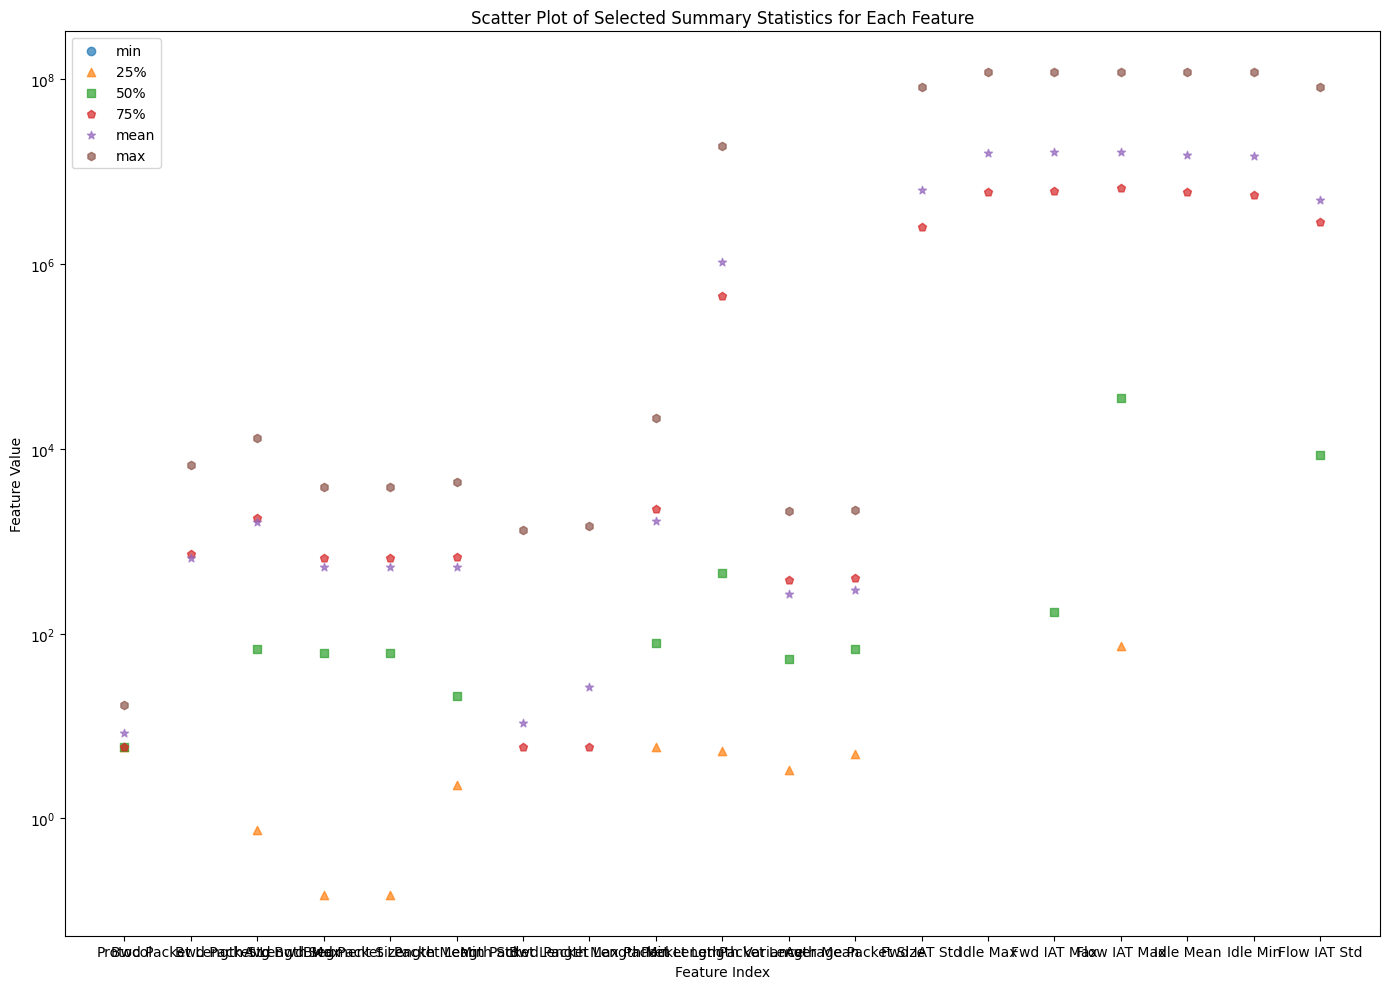

In [ ]:
# Символы для различных статистик сводки (обозначение точек на графике)
markers = ['o', '^', 's', 'p', '*', 'h']

# Расчёт статистик сводки для каждого признака
summary_stats = {
    'min': numeric_df.min(axis=0), # Минимальное значение для каждого признака
    '25%': np.percentile(numeric_df, 25, axis=0), # 25-й перцентиль для каждого признака
    '50%': np.percentile(numeric_df, 50, axis=0), # Медиана (50-й перцентиль) для каждого признака
    '75%': np.percentile(numeric_df, 75, axis=0), # 75-й перцентиль для каждого признака
    'mean': numeric_df.mean(axis=0), # Среднее значение для каждого признака
    'max': numeric_df.max(axis=0) # Максимальное значение для каждого признака
}

# Создание диаграммы рассеяния для статистик сводки
plt.figure(figsize=(14, 10))

# Построение точек для каждой статистики сводки
for idx, (stat, marker) in enumerate(zip(summary_stats.keys(), markers)):
    plt.scatter(np.arange(len(top_features)), summary_stats[stat][:len(top_features)], marker=marker, alpha=0.7, label=stat)

# Добавление подписей и заголовка
plt.legend(loc='best') # Легенда наилучшего расположения
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.yscale('log') # Логарифмическая шкала для оси Y
plt.title('Scatter Plot of Selected Summary Statistics for Each Feature')
plt.xticks(np.arange(len(top_features)), top_features) # Метки на оси X
plt.tight_layout()
plt.show() # Отображение графика


In [ ]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = numeric_df.drop(columns=['LabelEncoded'])
y = numeric_df['LabelEncoded']

# Разделение данных на тренировочный и тестовый наборы с сохранением пропорций
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Вывод размеров наборов данных
print("Размер тренировочного набора данных: ", X_train.shape)
print("Размер тестового набора данных: ", X_test.shape)

# Вывод пропорций в исходных данных
print("\nИсходные пропорции классов в данных:")
print(y.value_counts(normalize=True))

# Вывод пропорций в тренировочном наборе данных
print("\nПропорции классов в тренировочном наборе данных:")
print(y_train.value_counts(normalize=True))

# Вывод пропорций в тестовом наборе данных
print("\nПропорции классов в тестовом наборе данных:")
print(y_test.value_counts(normalize=True))


Размер тренировочного набора данных:  (38967, 19)
Размер тестового набора данных:  (16701, 19)

Исходные пропорции классов в данных:
LabelEncoded
0    0.5
1    0.5
Name: proportion, dtype: float64

Пропорции классов в тренировочном наборе данных:
LabelEncoded
1    0.500013
0    0.499987
Name: proportion, dtype: float64

Пропорции классов в тестовом наборе данных:
LabelEncoded
0    0.50003
1    0.49997
Name: proportion, dtype: float64


Нормализация данных

In [ ]:
# Нормализация данных на обучающей выборке
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)

# Применение нормализации к тестовой выборке
X_test_normalized = scaler.transform(X_test)

# Преобразование нормализованных данных обратно в DataFrame
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.columns)

In [ ]:
X_train_normalized.head()

,Protocol,Bwd Packet Length Std,Bwd Packet Length Max,Avg Bwd Segment Size,Bwd Packet Length Mean,Packet Length Std,Min Packet Length,Bwd Packet Length Min,Max Packet Length,Packet Length Variance,Packet Length Mean,Average Packet Size,Fwd IAT Std,Idle Max,Fwd IAT Max,Flow IAT Max,Idle Mean,Idle Min,Flow IAT Std
0,0.352941,0.000000,0.000000,0.000000,0.000000,0.001845,0.000000,0.00000,0.000639,0.000003,0.003338,0.004363,0.000000,0.000000,0.000002,1.260504e-06,0.000000,0.000000,6.031751e-07
1,0.352941,0.000000,0.000460,0.001547,0.001547,0.000000,0.004511,0.00411,0.000274,0.000000,0.002861,0.004208,0.000000,0.000000,0.000000,8.823529e-07,0.000000,0.000000,0.000000e+00
2,0.352941,0.472528,0.448128,0.598710,0.598710,0.480110,0.000000,0.00000,0.266667,0.230370,0.397461,0.419643,0.372596,0.696639,0.696639,6.966387e-01,0.378992,0.061108,3.123360e-01
3,0.352941,0.000000,0.000000,0.000000,0.000000,0.000000,0.004511,0.00000,0.000274,0.000000,0.002861,0.003366,0.067263,0.094118,0.094118,9.411765e-02,0.094118,0.094118,7.344166e-02
4,0.352941,0.401391,0.555556,0.498410,0.498410,0.428495,0.000000,0.00000,0.330594,0.183500,0.380342,0.399519,0.385817,0.712605,0.712605,7.126050e-01,0.712605,0.712605,3.083990e-01


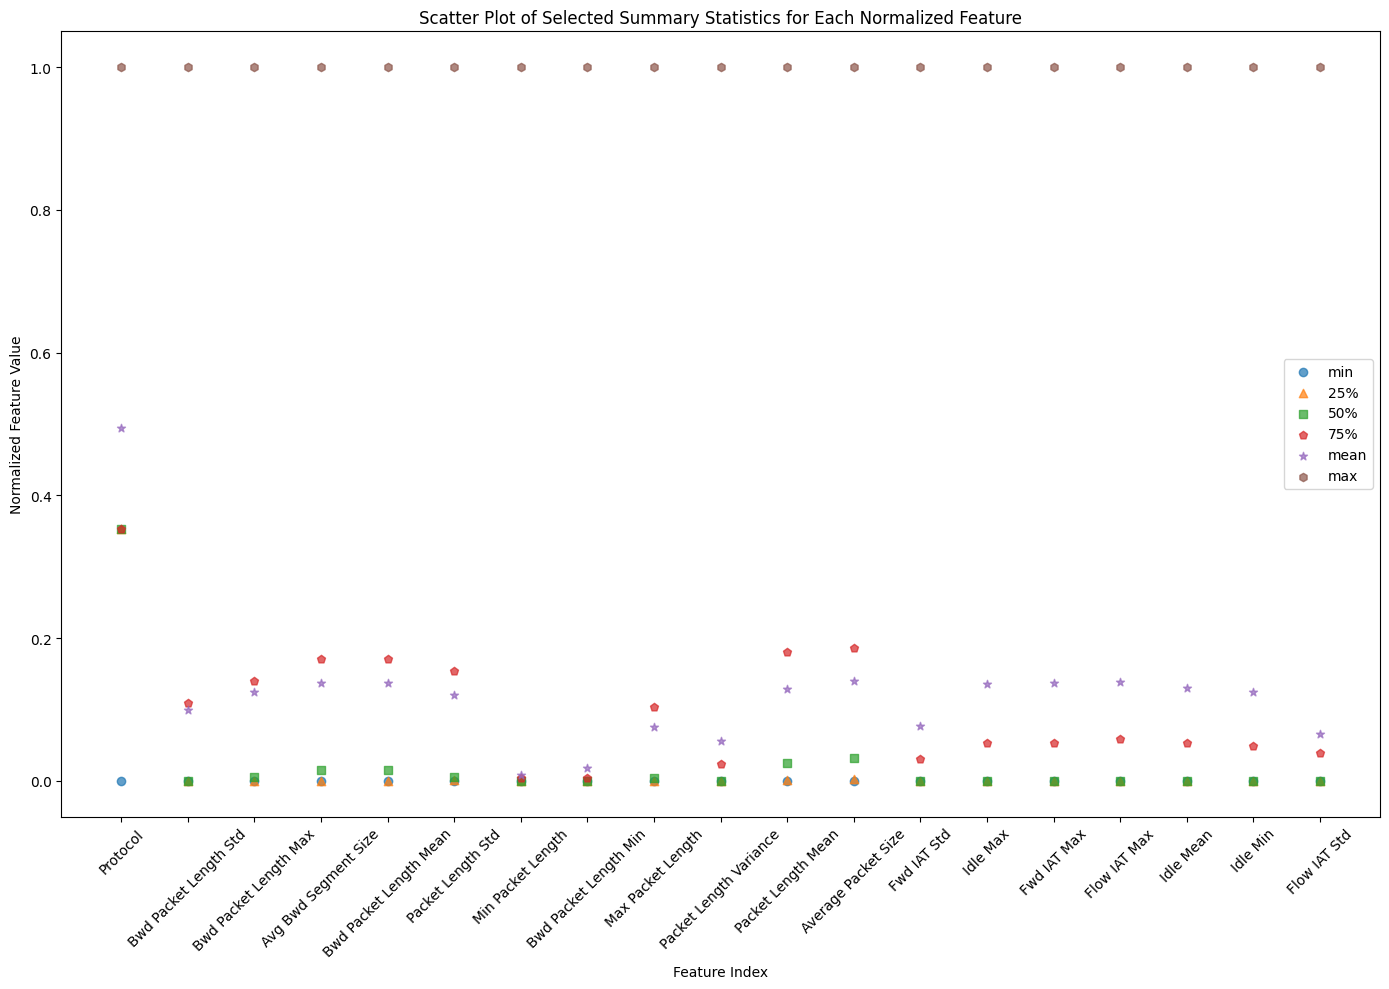

In [ ]:
# Символы для различных статистик сводки (обозначение точек на графике)
markers = ['o', '^', 's', 'p', '*', 'h']

# Расчёт статистик сводки для каждого нормализованного признака
summary_stats_normalized = {
    'min': X_train_normalized.min(axis=0),  # Минимальное значение для каждого признака
    '25%': np.percentile(X_train_normalized, 25, axis=0),  # 25-й перцентиль для каждого признака
    '50%': np.percentile(X_train_normalized, 50, axis=0),  # Медиана (50-й перцентиль) для каждого признака
    '75%': np.percentile(X_train_normalized, 75, axis=0),  # 75-й перцентиль для каждого признака
    'mean': X_train_normalized.mean(axis=0),  # Среднее значение для каждого признака
    'max': X_train_normalized.max(axis=0)  # Максимальное значение для каждого признака
}

# Создание диаграммы рассеяния для статистик сводки нормализованных данных
plt.figure(figsize=(14, 10))

# Построение точек для каждой статистики сводки
for idx, (stat, marker) in enumerate(zip(summary_stats_normalized.keys(), markers)):
    plt.scatter(np.arange(len(X_train.columns)), summary_stats_normalized[stat], marker=marker, alpha=0.7, label=stat)

# Добавление подписей и заголовка
plt.legend(loc='best')
plt.xlabel('Feature Index')
plt.ylabel('Normalized Feature Value')
plt.title('Scatter Plot of Selected Summary Statistics for Each Normalized Feature')
plt.xticks(np.arange(len(X_train.columns)), X_train.columns, rotation=45)
plt.tight_layout()
plt.show()

## Построение моделей SVM

Используется метод решетчатого поиска. Модель SVM настраивается с помощью 5 основных параметров:
- Kernel (ядро)
- С (параметр регуляризации)
- Gamma (гамма, только для rbf, poly и sigmoid ядер)
- Degree (степень, только для poly ядра)
- Coef0 (коэффициент, только для poly и sigmoid ядер)

In [ ]:
# Определение одного набора параметров для настройки модели
params = {
    'kernel': 'rbf',  # Используем радиальную базисную функцию
    'C': 0.1,           # Параметр регуляризации
    'gamma': 0.1      # Коэффициент ядра
}

# Инициализация и настройка модели SVM с использованием одного набора параметров
model = SVC(**params)
print(f"Обучение модели с параметрами: {params}")

# Обучение модели
model.fit(X_train_normalized, y_train)

# Предсказание на тестовых данных
y_pred = model.predict(X_test_normalized)

# Оценка модели с использованием метрик
print("Оценка модели:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
print(f"ROC AUC Score: {roc_auc_score(y_test, model.decision_function(X_test_normalized), multi_class='ovr')}")

# Вывод подробного отчета по классификации
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Обучение модели с параметрами: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1}
Оценка модели:
Accuracy: 0.7863600981977127
Precision: 0.8414463541298849
Recall: 0.7863600981977127
F1 Score: 0.7773845336852159
ROC AUC Score: 0.8967298620338058

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.59      0.73      8351
           1       0.70      0.99      0.82      8350

    accuracy                           0.79     16701
   macro avg       0.84      0.79      0.78     16701
weighted avg       0.84      0.79      0.78     16701



In [ ]:


# Определение функции оценки (скора), использующей метрику точности
def custom_scorer(model, X, y):
    y_pred = model.predict(X)  # Предсказание меток
    return accuracy_score(y, y_pred)  # Возвращение метрики точности

# Пользовательский класс для GridSearchCV, который выводит результаты каждой модели
class CustomGridSearchCV(GridSearchCV):
    def fit(self, X, y=None, **fit_params):
        # Получаем общее количество комбинаций параметров
        n_candidates = len(list(ParameterGrid(self.param_grid)))  # Подсчет количества комбинаций параметров
        print(f"Обучение {n_candidates} моделей...")

        # Инициализация переменных для отслеживания лучшей модели и параметров
        best_score = -1
        best_estimator = None
        best_params = None

        # Проход по всем комбинациям параметров
        for params in ParameterGrid(self.param_grid):
            print(f"\nОбучение модели с параметрами: {params}")
            model = clone(self.estimator)  # Создание копии модели
            model.set_params(**params)  # Установка параметров модели
            model.fit(X, y, **fit_params)  # Обучение модели

            # Предсказание на тестовых данных
            y_pred = model.predict(X_test_normalized)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            roc_auc = roc_auc_score(y_test, model.decision_function(X_test_normalized), multi_class='ovr')

            # Вывод метрик текущей модели
            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"F1 Score: {f1}")
            print(f"ROC AUC Score: {roc_auc}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

            # Оценка модели с использованием пользовательской функции оценки (скора)
            score = custom_scorer(model, X_test_normalized, y_test)
            if score > best_score:
                best_score = score  # Обновление лучшего скорового значения
                best_estimator = model  # Сохранение модели с наилучшими параметрами
                best_params = params  # Сохранение параметров модели

        # Сохранение лучшей модели и параметров
        self.best_estimator_ = best_estimator  # Установка наилучшего оценщика
        self.best_params_ = best_params  # Установка наилучших параметров
        self.best_score_ = best_score  # Установка наилучшего скорового значения

        return self  # Возвращение текущего объекта


In [ ]:
# Определение сетки параметров для настройки модели
param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1 ],
    'coef0': [0, 0.1]  # Только для poly и sigmoid ядер
}

# Инициализация и настройка модели SVM с использованием CustomGridSearchCV
custom_grid_search = CustomGridSearchCV(SVC(), param_grid, refit=True, verbose=2)
print("Начало обучения модели с параметрами из решетчатого поиска...")

# Обучение модели
custom_grid_search.fit(X_train_normalized, y_train)

# Вывод наилучших параметров
best_params = custom_grid_search.best_params_
print("Лучшие параметры:")
print(best_params)

# Оценка модели с использованием лучших параметров
best_model = custom_grid_search.best_estimator_
y_pred = best_model.predict(X_test_normalized)

print("Оценка модели с наилучшими параметрами:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
print(f"ROC AUC Score: {roc_auc_score(y_test, best_model.decision_function(X_test_normalized), multi_class='ovr')}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Начало обучения модели с параметрами из решетчатого поиска...
Обучение 12 моделей...

Обучение модели с параметрами: {'C': 0.1, 'coef0': 0, 'gamma': 1, 'kernel': 'rbf'}
Accuracy: 0.8229447338482726
Precision: 0.8617529426714855
Recall: 0.8229447338482726
F1 Score: 0.8180674614562998
ROC AUC Score: 0.9221081702001339

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.66      0.79      8351
           1       0.74      0.99      0.85      8350

    accuracy                           0.82     16701
   macro avg       0.86      0.82      0.82     16701
weighted avg       0.86      0.82      0.82     16701


Обучение модели с параметрами: {'C': 0.1, 'coef0': 0, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 0.7863600981977127
Precision: 0.8414463541298849
Recall: 0.7863600981977127
F1 Score: 0.7773845336852159
ROC AUC Score: 0.8967298620338058

Classification Report:
              precision    recall  f1-score   support

           0     

In [ ]:
# Определение сетки параметров для настройки модели
param_grid = {
    'kernel': ['rbf'],
    'C': [10],
    'gamma': [10, 15, 20],
}

# Инициализация и настройка модели SVM с использованием CustomGridSearchCV
custom_grid_search = CustomGridSearchCV(SVC(), param_grid, refit=True, verbose=2)
print("Начало обучения модели с параметрами из решетчатого поиска...")

# Обучение модели
custom_grid_search.fit(X_train_normalized, y_train)

# Вывод наилучших параметров
best_params = custom_grid_search.best_params_
print("Лучшие параметры:")
print(best_params)

# Оценка модели с использованием лучших параметров
best_model = custom_grid_search.best_estimator_
y_pred = best_model.predict(X_test_normalized)

print("Оценка модели с наилучшими параметрами:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
print(f"ROC AUC Score: {roc_auc_score(y_test, best_model.decision_function(X_test_normalized), multi_class='ovr')}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Начало обучения модели с параметрами из решетчатого поиска...
Обучение 3 моделей...

Обучение модели с параметрами: {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
Accuracy: 0.9061134063828513
Precision: 0.9149716120579321
Recall: 0.9061134063828513
F1 Score: 0.9056101352155008
ROC AUC Score: 0.9522422930453307

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      8351
           1       0.85      0.98      0.91      8350

    accuracy                           0.91     16701
   macro avg       0.91      0.91      0.91     16701
weighted avg       0.91      0.91      0.91     16701


Обучение модели с параметрами: {'C': 10, 'gamma': 15, 'kernel': 'rbf'}
Accuracy: 0.9103646488234237
Precision: 0.9192706180605594
Recall: 0.9103646488234237
F1 Score: 0.909886539762766
ROC AUC Score: 0.95518433376332

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.90    

## Выбор наилучшего результата

Выводы по лучшему результату
Наилучшие параметры модели:
C: 10

gamma: 20

kernel: 'rbf'

Оценка модели с наилучшими параметрами:
Accuracy: 0.9116819352134603

Наилучшая производительность модели достигнута при параметрах C = 10, gamma = 20, и использовании радиальной базисной функции (rbf) в качестве ядра.

Точность (Accuracy): Модель достигает точности 91.17%.

Precision (Прецизионность): показывает, какая доля позитивных наблюдений являются действительно позитивными 0.9203191390468769.

Recall (Полнота): показывает, какая доля действительно позитивных наблюдений была правильно предсказана 0.9116819352134603

F1 Score (F1-мера): гармоническое среднее значение прецизионности и полноты - оценка модели по обоим показателям 0.9112262941407133

ROC AUC (Receiver Operating Characteristic Area Under the Curve): показывает, насколько модель способна различать классы. ROC-кривая -  зависимость между долей истинно положтельных результатов и долей ложноположительных. AUC - площадь под кривой, измеряет общее качество модели = 0.9570642190651626, что близо к 1, но не идеально.

Macro Avg (Макросреднее): арифметическое прецизионности полноты и F1-меры для всех классов, не учитывая их количество (support).

Weighted Avg (Взвешенное среднее): учитывает support каждого класса и рассчитывает средневзвешенные значения прецизионности, полноты и F1-меры.

# Документация

Первоначально исходный набор данных был сбалансирован, а также увеличен в 0.05 раз для ускорения обучения. Далее данные были нормализованы и разделены на тестовый и тренировочный наборы данны в соотношенияя 0.3/0.7.

Было принято решение не исключать мультиколлениарные признаки для обучения модели, поскольку точность с исключением признаков не превосходила 72%. С увеличением количества признаков с 8 до 24 было достигнуто увеличение в точности до 82% без изменения параметров.

Было проанализировано несколько ядер перед проведением решетчатого поиска:
- `linear`: Линейное ядро, использующее линейную гиперплоскость для разделения данных.
- `poly`: Полиномиальное ядро, учитывающее нелинейные разделяющие поверхности.
- `rbf`: Радиальная базисная функция (Radial Basis Function), наиболее часто используемое нелинейное ядро.
- `sigmoid`: Сигмоидальная функция, аналогичная функции активации в нейронных сетях.
Лучше и быстрее всего себя показало ядро `rbf`, которое было выбрано для поиска оптимальных параметров модели.


Оптимальными параметрами являются `C: 10`, `gamma: 20`, `kernel: 'rbf'` с точностью `91.17%`.